<a href="https://colab.research.google.com/github/vaishnavi-varaganti/Sentimental_Analysis_On_Youtube_Comments/blob/main/Sentimental_Analysis_On_Youtube_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import walk
import re
import csv
import pandas as pd
from bs4 import BeautifulSoup
import spacy

In [2]:
import zipfile
# Path to your ZIP file
zip_path = '/content/C_78DM8fG6E.zip'
# Path to extract the contents
extracted_path = '/content/'
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Files have been extracted to:", extracted_path)

Files have been extracted to: /content/


In [3]:
import os
import pandas as pd
folder_path = "/content/"
df = None
# Iterate through the contents of the folder
for filename in os.listdir(folder_path):
    # Join the folder path with the filename to get the full path
    full_path = os.path.join(folder_path, filename)
    # Check if the current item is a file and has a .csv extension
    if os.path.isfile(full_path) and filename.endswith('.csv'):
        print(full_path)
        temp_df = pd.read_csv(full_path, skipinitialspace=True)
        # Combine the DataFrames
        if df is None:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], ignore_index=True)
# Now `df` contains the combined data from all CSV files

/content/vJefOB8kec8.csv
/content/WY518YRfs5M.csv
/content/xoVJKj8lcNQ.csv
/content/SVcsDDABEkM.csv
/content/-qReeg7imGc.csv
/content/VzUmLAUPSQo.csv
/content/XKMvk5hWDfo.csv
/content/aZ5EsdnpLMI.csv
/content/2yd18z6iSyk.csv
/content/RdAQnkDzGvc.csv
/content/rb7NddXDdxs.csv
/content/USsh-XK6s6U.csv
/content/LWiM-LuRe6w.csv
/content/eXdVDhOGqoE.csv
/content/C_78DM8fG6E.csv
/content/Tpq3hRt0pmw.csv
/content/qrvK_KuIeJk.csv
/content/gMsQO5u7-NQ.csv
/content/hJP5GqnTrNo.csv
/content/540vzMlf-54.csv
/content/uJnhh7YSr5Q.csv
/content/cqc0xni25n0.csv
/content/b76gsOSkHB4.csv
/content/Yd0yQ9yxSYY.csv
/content/_x9AwxfjxvE.csv
/content/880TBXMuzmk.csv


In [4]:
nan_indices = df['Comment'].isna()
# Replace NaN values with empty strings
df['Comment'] = df['Comment'].fillna('')

In [5]:
def clean_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    # Remove special ASCII symbols
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Remove asterisks around each letter in the phrase and words attached to @
    text = re.sub(r'\*|@\w+|@|\?|!', '', text)
    return text.strip()

In [6]:
# Apply clean_text function only to non-null values
df['clean_comment'] = df['Comment'].apply(lambda x: clean_text(x) if not pd.isnull(x) else x)

<ipython-input-5-f0f29cc38ca6>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [7]:
def filter_sentences(text):
    sentences = text.split('.')
    filtered_sentences = [sentence for sentence in sentences if len(sentence.split()) >= 5]
    return '. '.join(filtered_sentences)
# Apply the function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(filter_sentences)

In [8]:
# Function to filter out rows with empty 'clean_comment' values
def filter_empty_comments(row):
    return row['clean_comment'] != '' or row['clean_comment'] != None
# Apply the function to filter out rows with empty 'clean_comment' values
df = df[df.apply(filter_empty_comments, axis=1)]

In [9]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [10]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [13]:
df["tokens"] = df["clean_comment"].apply(prepare_text_for_lda)

In [14]:
def get_topic_dict(text):
    dict_ = {}
    text = text.split("+")
    for i in range(len(text)):
        text[i] = text[i].strip()
        temp = text[i].split("*")
        if len(temp) >= 2 and temp[0] != "":
            dict_[temp[1][1:-1]] = float(re.search(r'\d+', temp[0]).group())
    return dict_

In [15]:
import gensim
from gensim import corpora
def get_topics(tokens):
    if len(tokens) != 0:
        dictionary = corpora.Dictionary([tokens])
        corpus = [dictionary.doc2bow(tokens)]
        NUM_TOPICS = 1
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
        ldamodel.save('model5.gensim')
        topics = ldamodel.print_topics(num_words=len(tokens))
        return get_topic_dict(topics[0][1])
    else:
        return {}

In [16]:
df['topics'] = df["tokens"].apply(get_topics)

In [17]:
df = df[df['topics'] != {}]

In [18]:
for i in df['topics']:
    print(i)

Streaming output truncated to the last 5000 lines.
{'connect': 0.0, 'humans': 0.0, 'model': 0.0}
{'destroy': 0.0, 'firer': 0.0, 'playing': 0.0, 'smart': 0.0}
{'create': 0.0, 'cameron': 0.0, 'control': 0.0, 'device': 0.0, 'easily': 0.0, 'fetch': 0.0, 'james': 0.0, 'machine': 0.0, 'potentially': 0.0, 'relationship': 0.0}
{'camera': 0.0, 'write': 0.0, 'using': 0.0, 'people': 0.0, 'wonder': 0.0, 'whenever': 0.0, 'unintended': 0.0, 'think': 0.0, 'system': 0.0, 'seem': 0.0, 'research': 0.0, 'rely': 0.0, 'reduce': 0.0, 'produce': 0.0, 'paper': 0.0, 'ability': 0.0, 'instead': 0.0, 'implementation': 0.0, 'impact': 0.0, 'forget': 0.0, 'essay': 0.0, 'enable': 0.0, 'education': 0.0, 'critically': 0.0, 'consequence': 0.0, 'completely': 0.0, 'cheater': 0.0, 'actually': 0.0, 'would': 0.0, 'mirror': 0.0}
{'adapt': 0.0, 'brain': 0.0, 'cybernetic': 0.0, 'increase': 0.0, 'maybe': 0.0, 'power': 0.0}
{'disservice': 0.0, 'humanity': 0.0, 'sociopath': 0.0, 'talking': 0.0, 'tool': 0.0}
{'2minutes': 0.0, 'firs

In [19]:
df.to_csv("/content/combined_csv_cleaned_with_tokens_and_topics.csv", index=False)

In [32]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [33]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('punkt')
sia = SentimentIntensityAnalyzer()
# Function to get sentiment label based on compound score
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
# Perform sentiment analysis on each comment
sentiment_labels = []
for comment in df['clean_comment']:
    # Tokenize the comment
    tokens = nltk.word_tokenize(comment)
    # Get English stop words from NLTK
    stop_words = set(stopwords.words('english'))
    # Remove stop words from the tokens
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    # Join the filtered tokens back into a sentence
    filtered_text = ' '.join(filtered_tokens)
    # Get sentiment scores
    sentiment_scores = sia.polarity_scores(comment)
    # Get sentiment label based on compound score
    sentiment_label = get_sentiment_label(sentiment_scores['compound'])
    sentiment_labels.append(sentiment_label)
# Add sentiment labels to DataFrame
df['sentiment'] = sentiment_labels

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
df['sentiment']

,sentiment
0,Positive
1,Positive
2,Positive
4,Neutral
6,Neutral
...,...
83897,Negative
83899,Negative
83900,Neutral
83901,Positive


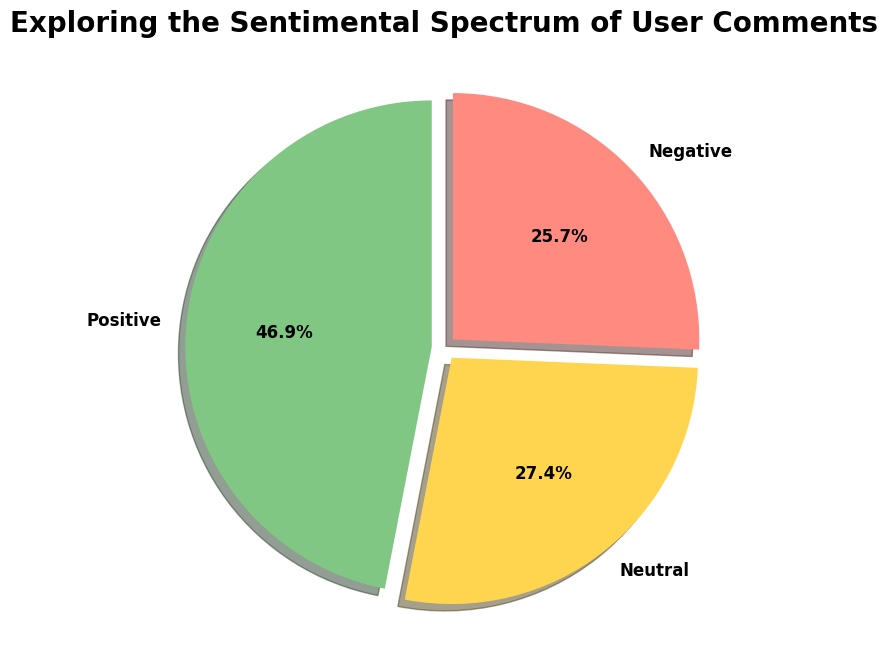

In [42]:
import matplotlib.pyplot as plt
# Assuming df['sentiment'] contains the sentiment labels
sentiment_counts = df['sentiment'].value_counts()
# Enhanced pie chart styling
plt.figure(figsize=(10, 8))
explode = (0.05, 0.05, 0.05)  # Slightly separate all slices
colors = ['#81C784', '#FFD54F', '#FF8A80']  # Updated pastel colors
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)
# Unique title
plt.title('Exploring the Sentimental Spectrum of User Comments',
          fontsize=20, weight='bold', color='black')
plt.show()

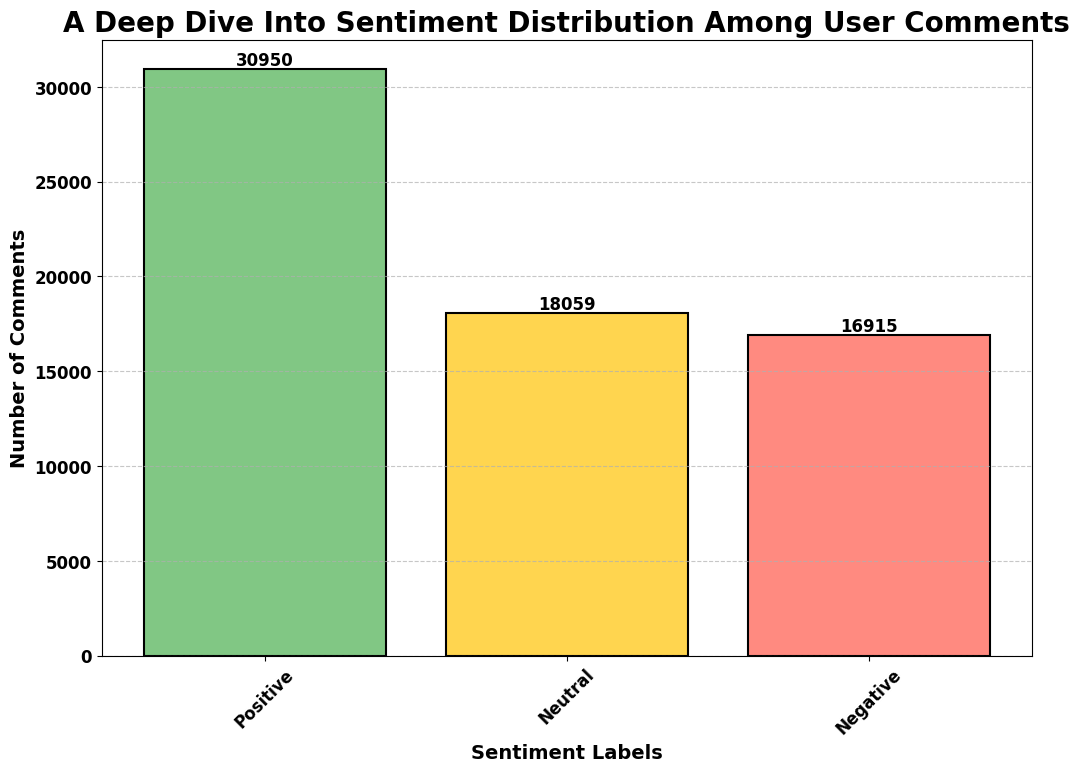

In [47]:
import matplotlib.pyplot as plt
# Assuming df['sentiment'] contains the sentiment labels
sentiment_counts = df['sentiment'].value_counts()
# Enhanced bar chart styling
plt.figure(figsize=(12, 8))
plt.bar(
    sentiment_counts.index,
    sentiment_counts.values,
    color=['#81C784', '#FFD54F', '#FF8A80'],  # Updated pastel colors
    edgecolor='black',  # Add border to bars
    linewidth=1.5  # Border thickness
)
# Adding labels and title
plt.xlabel('Sentiment Labels', fontsize=14, weight='bold')
plt.ylabel('Number of Comments', fontsize=14, weight='bold')
plt.title('A Deep Dive Into Sentiment Distribution Among User Comments',
          fontsize=20, weight='bold', color='black')
# Adding value annotations on top of bars
for i, value in enumerate(sentiment_counts.values):
    plt.text(i, value + 200, f'{value}', ha='center', fontsize=12, weight='bold')
# Rotate x-axis labels for better readability
plt.xticks(fontsize=12, weight='bold', rotation=45)
plt.yticks(fontsize=12, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add light gridlines for better readability
plt.show()

In [48]:
pip install wordcloud

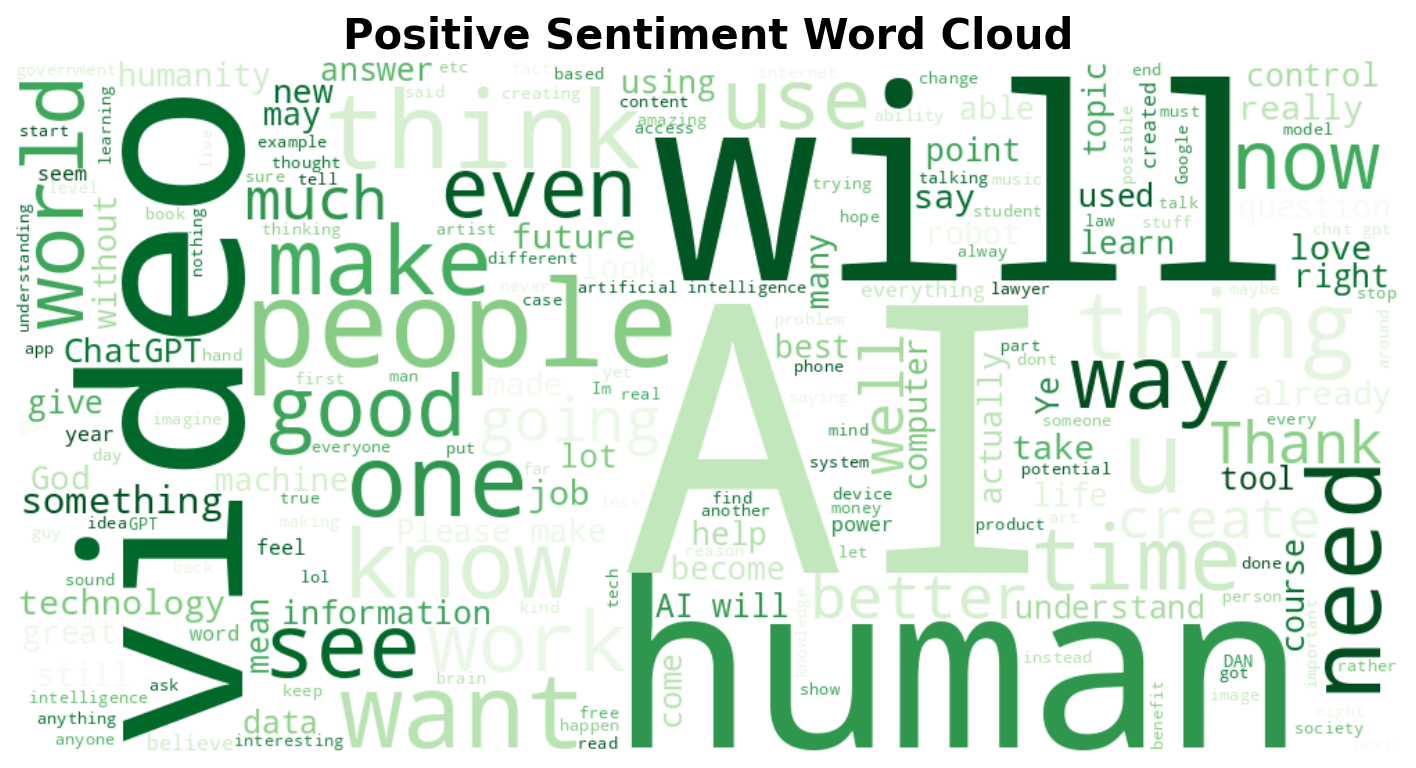

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Function to generate and display a styled word cloud
def generate_word_cloud(text, title, colormap):
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=colormap,
        max_words=200,
        contour_width=1,
        contour_color='black'  # Add a slight contour for aesthetics
    ).generate(text)
    plt.figure(figsize=(12, 6), dpi=150)  # High DPI for clarity
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, weight='bold', color='black')  # Bold and styled title
    plt.show()
# Filter comments by sentiment
positive_comments = ' '.join(df[df['sentiment'] == 'Positive']['clean_comment'])
# Generate word clouds with distinct styles for each sentiment
generate_word_cloud(positive_comments, 'Positive Sentiment Word Cloud', 'Greens')

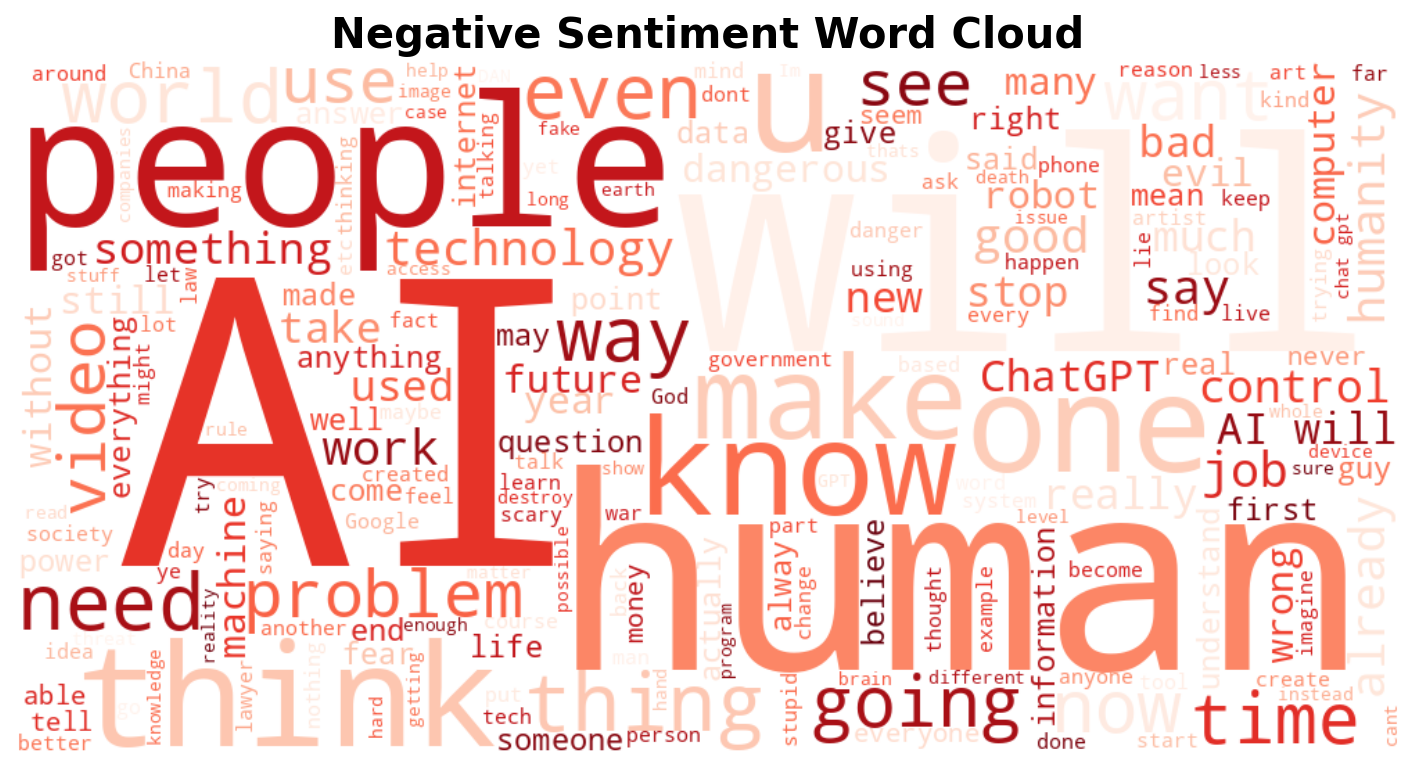

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Function to generate and display a styled word cloud
def generate_word_cloud(text, title, colormap):
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=colormap,
        max_words=200,
        contour_width=1,
        contour_color='black'  # Add a slight contour for aesthetics
    ).generate(text)
    plt.figure(figsize=(12, 6), dpi=150)  # High DPI for clarity
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, weight='bold', color='black')  # Bold and styled title
    plt.show()
# Filter comments by sentiment
negative_comments = ' '.join(df[df['sentiment'] == 'Negative']['clean_comment'])
# Generate word clouds with distinct styles for each sentiment
generate_word_cloud(negative_comments, 'Negative Sentiment Word Cloud', 'Reds')

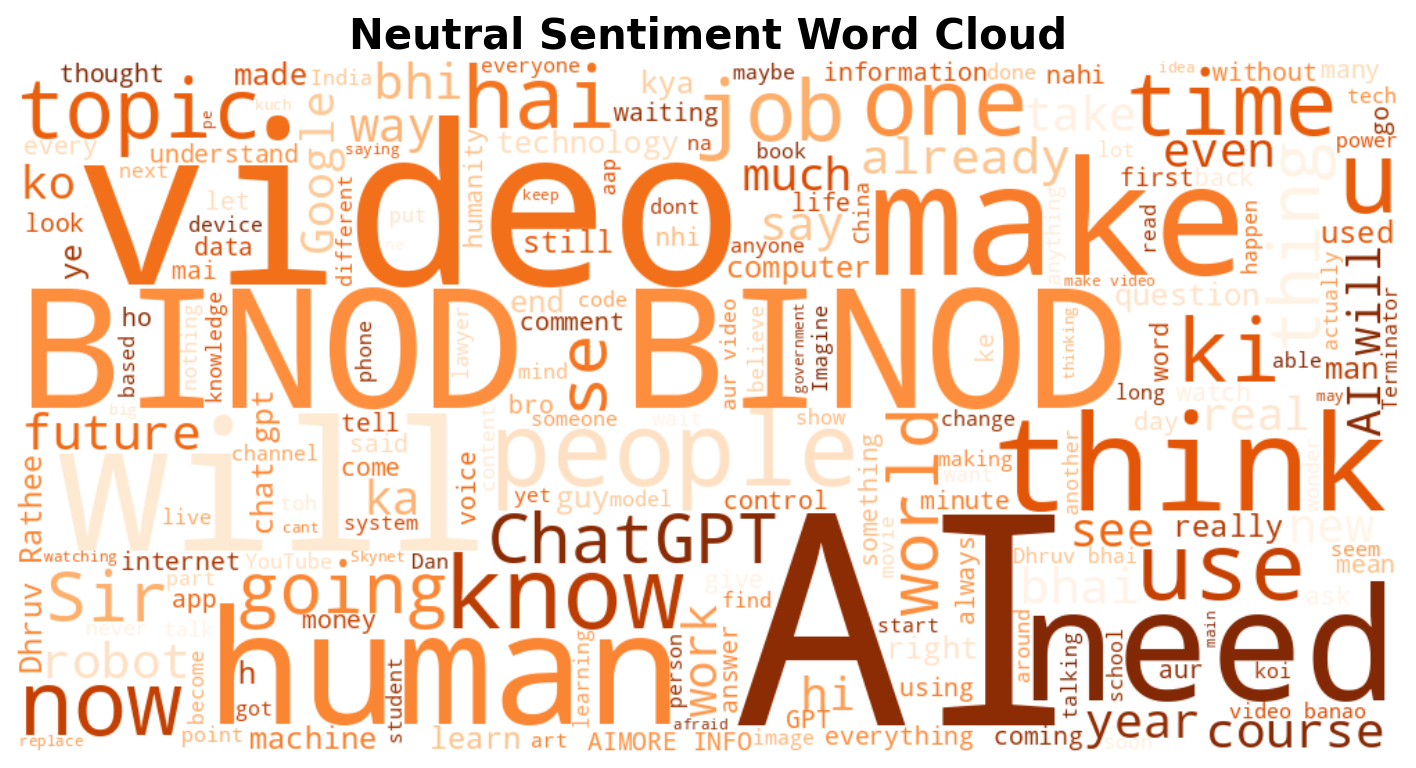

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Function to generate and display a styled word cloud
def generate_word_cloud(text, title, colormap):
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        colormap=colormap,
        max_words=200,
        contour_width=1,
        contour_color='black'  # Add a slight contour for aesthetics
    ).generate(text)
    plt.figure(figsize=(12, 6), dpi=150)  # High DPI for clarity
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, weight='bold', color='black')  # Bold and styled title
    plt.show()
# Filter comments by sentiment
neutral_comments = ' '.join(df[df['sentiment'] == 'Neutral']['clean_comment'])
# Generate word clouds with distinct styles for each sentiment
generate_word_cloud(neutral_comments, 'Neutral Sentiment Word Cloud', 'Oranges')

In [65]:
print(df.head())  # View the first few rows of your DataFrame
print(df.dtypes)  # Check the data types of your columns


    Comment Type                                            Comment  \
0   Main Comment  🤖 Join my AI Course: <a href="https://academy....   
1  Reply Comment  1st ❤️<br>Edit - Sir, you are intelligent than...   
2  Reply Comment  Dhruv Is Not Pregnant , But he Never Fails To ...   
4  Reply Comment           Bhkto ki fact se itni fatt ti kyu hai 😂😂   
6   Main Comment  I request to India government Please stop the ...   

                   Author  Likes          Published At  \
0            @dhruvrathee   3044  2023-07-16T15:13:09Z   
1             @surajk5102     95  2023-07-16T15:13:20Z   
2              @Maddy._.7    100  2023-07-16T15:13:40Z   
4               @Babannda     57  2023-07-16T15:13:50Z   
6  @manojkumargomango6867      0  2024-02-23T15:10:16Z   

                                       clean_comment  \
0  Join my AI Course: https://academy. com/chatgp...   
1  1st Edit - Sir, you are intelligent than other...   
2  Dhruv Is Not Pregnant , But he Never Fails To ...   


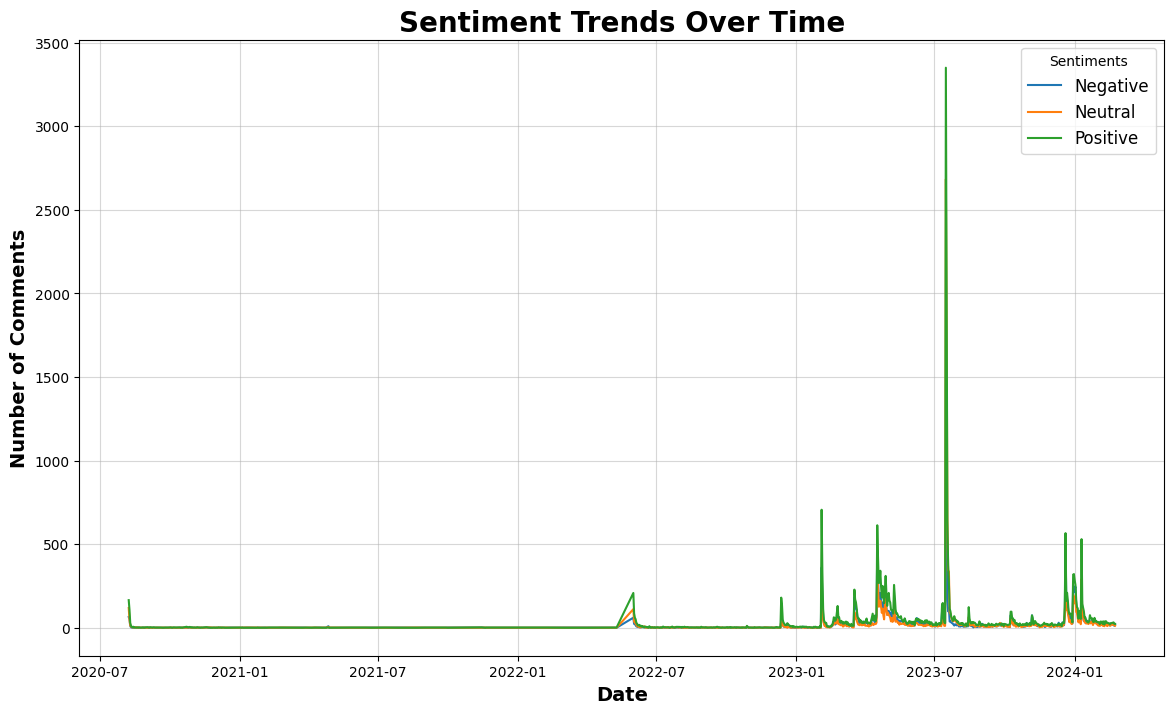

In [68]:
# Convert 'Published At' column to datetime
df['timestamp'] = pd.to_datetime(df['Published At'])  # Rename and ensure datetime format
# Extract the date from the timestamp
df['date'] = df['timestamp'].dt.date
# Group sentiment counts by date
sentiment_over_time = df.groupby('date')['sentiment'].value_counts().unstack().fillna(0)
# Plot sentiment distribution over time
sentiment_over_time.plot(kind='line', figsize=(14, 8))
plt.title('Sentiment Trends Over Time', fontsize=20, weight='bold')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('Number of Comments', fontsize=14, weight='bold')
plt.legend(title='Sentiments', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

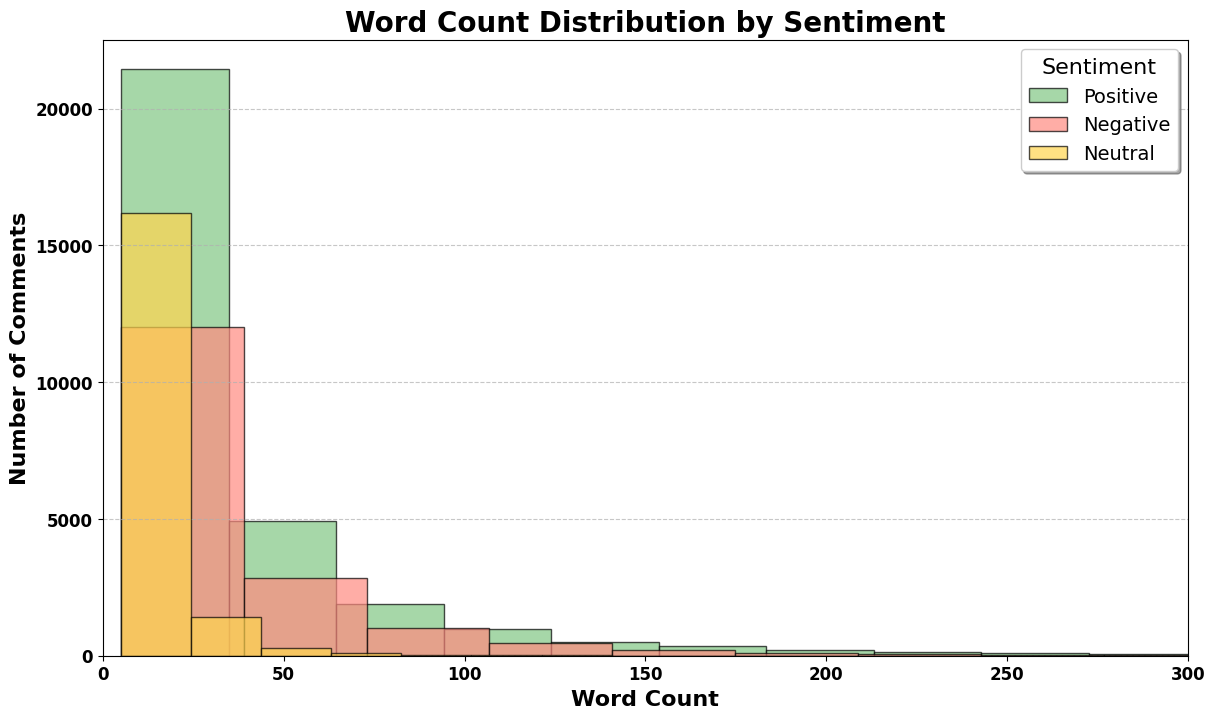

In [72]:
# Add word count column
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))
# Correlation between word count and sentiment
plt.figure(figsize=(14, 8))  # Increased figure size for better visibility
# Define colors for each sentiment
colors = {'Positive': '#81C784', 'Negative': '#FF8A80', 'Neutral': '#FFD54F'}
# Plot histograms with better styling
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_df = df[df['sentiment'] == sentiment]
    plt.hist(
        sentiment_df['word_count'],
        alpha=0.7,
        label=sentiment,
        bins=50,  # Increased number of bins for smoother distribution
        color=colors[sentiment],
        edgecolor='black'  # Add edges for better distinction
    )
# Set x-axis range from 0 to 300
plt.xlim(0, 300)
# Add title and labels with improved styling
plt.title('Word Count Distribution by Sentiment', fontsize=20, weight='bold', color='black')
plt.xlabel('Word Count', fontsize=16, weight='bold')
plt.ylabel('Number of Comments', fontsize=16, weight='bold')
# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add legend with improved placement and style
plt.legend(
    title='Sentiment',
    fontsize=14,
    title_fontsize=16,
    loc='upper right',
    fancybox=True,
    shadow=True
)
# Customize tick labels
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
# Display the plot
plt.show()

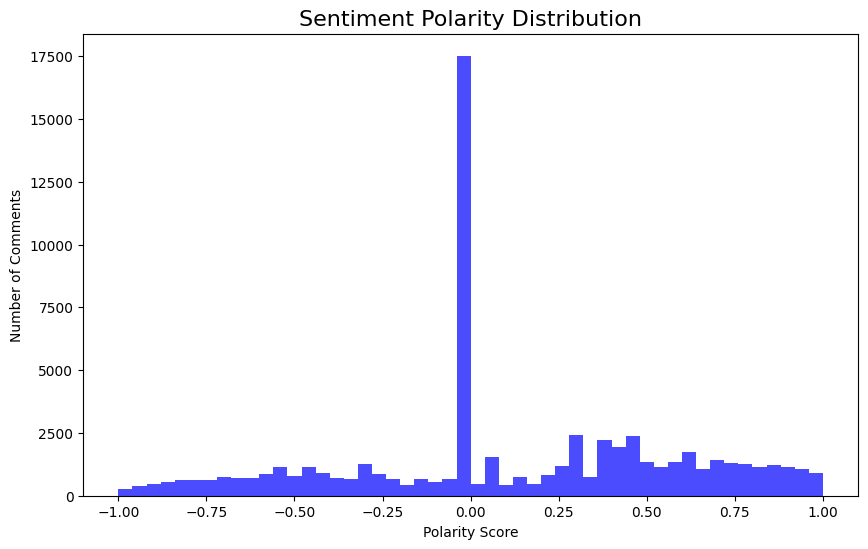

In [78]:
# Sentiment polarity histogram
polarity_scores = df['clean_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
plt.figure(figsize=(10, 6))
plt.hist(polarity_scores, bins=50, color='blue', alpha=0.7)
plt.title('Sentiment Polarity Distribution', fontsize=16)
plt.xlabel('Polarity Score')
plt.ylabel('Number of Comments')
plt.show()

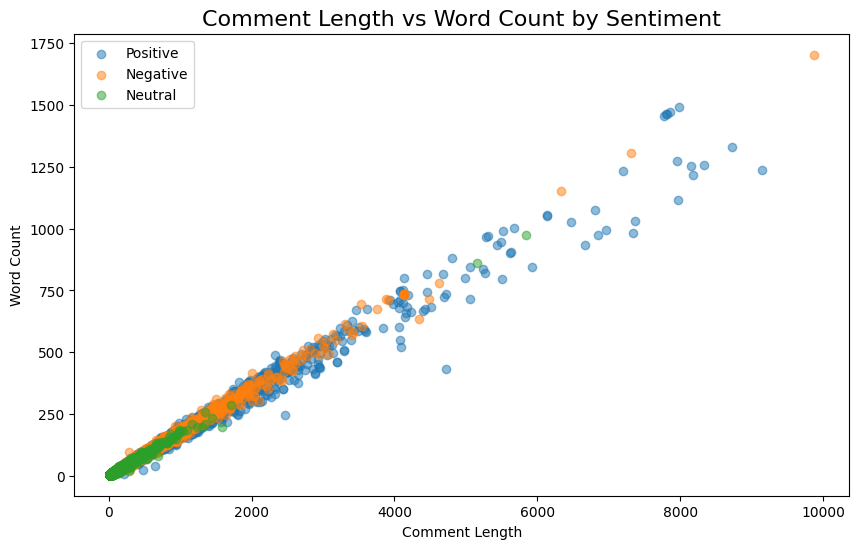

In [79]:
df['comment_length'] = df['clean_comment'].apply(len)
# Scatter plot of comment length vs sentiment
plt.figure(figsize=(10, 6))
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_df = df[df['sentiment'] == sentiment]
    plt.scatter(sentiment_df['comment_length'], sentiment_df['word_count'], alpha=0.5, label=sentiment)
plt.title('Comment Length vs Word Count by Sentiment', fontsize=16)
plt.xlabel('Comment Length')
plt.ylabel('Word Count')
plt.legend()
plt.show()